In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.To_Draw import Draw_avg_vel_r
from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap
from pprint import pprint

In [254]:
seed =10
N = 500
theta_random,omega,Kc = Normal(N,0,1,seed=seed)
omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 0.95
dt = 0.1
t = np.arange(0,10000,dt)
K = 4.1
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta= 0*omega,p_omega=omega)

In [255]:
dtheta_c = np.cumsum(dtheta,axis=0)
r_c = np.cumsum(rs,axis=0)
sum_time = 5000
t_sum = t[sum_time:]
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time
avg_r = (r_c[sum_time:]-r_c[:-sum_time])/sum_time

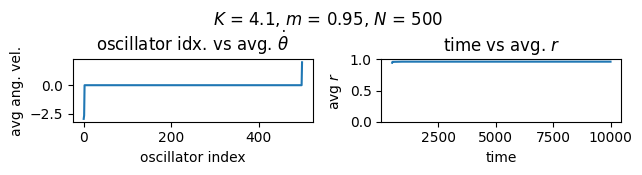

In [256]:
Draw_avg_vel_r(t_sum=t_sum,avg_r=avg_r,KmN=(K,m,N),avg_dtheta=avg_dtheta)

In [257]:
def to_cluster(idx,peaks_new,arg):
    C = idx,idx+1
    arg_C = peaks_new[C[0]],peaks_new[C[1]]
    cluster = arg[arg_C[0]:arg_C[1]]
    return cluster
def to_cluster_barg(idx,peaks_new):
    C = idx,idx+1
    arg_C = peaks_new[C[0]],peaks_new[C[1]]
    cluster = np.arange(arg_C[0],arg_C[1])
    return cluster
to_cstability = lambda x: np.mean(diff_dtheta[x[1:]])
to_mean_avg_d_o = lambda x: np.mean(avg_dtheta[index][x])
iter_time = 200*5
num = 0
for index in range(-iter_time,0):
    arg = np.argsort(avg_dtheta[index])
    SD = avg_dtheta[index][arg]
    diff_dtheta = np.diff([SD[0],*SD])
    peaks, P  = find_peaks(diff_dtheta, height=0.01)
    peaks = peaks[np.where((peaks<N)&(peaks>1))]
    try:
        peaks_new = np.array([peaks[0],*peaks])
    except IndexError:
        peaks_new = np.array([0,N])

    psize = np.diff(peaks_new)
    arg_psize = np.argsort(psize)[::-1]
    sort_psize = np.sort(psize)[::-1]
    clusters = np.array([to_cluster_barg(arg_psize[i],peaks_new) for i in range(len(arg_psize))],dtype=object)[:10]
    c_stability = np.array(list(map(to_cstability,clusters)))
    mean_omega = np.array(list(map(to_mean_avg_d_o,clusters)))
    
    if num==0:
        psize_array = sort_psize[:10]
        cluster_array = clusters
        c_stability_array = c_stability
        mean_omega_array = mean_omega
        num+=1
    else:
        cluster_array = np.c_[cluster_array,clusters]
        psize_array = np.c_[psize_array,sort_psize[:10]]
        c_stability_array = np.c_[c_stability_array,c_stability]
        mean_omega_array = np.c_[mean_omega_array,mean_omega]


# Is_group = np.where((np.std(psize_array,axis=1) == 0))#&(psize_array[:,-1]>10))
Is_group = np.where((np.std(mean_omega_array,axis=1) < 1e-2))#&(psize_array[:,-1]>10)) # 그룹을 개수로 판별하기 때문에 개수가 같아 그룹이 이동하면 그룹이 아닌걸로 판별해야 한다.
mean_group_s = np.mean(c_stability_array,axis=1)
Is_group_s = np.where((mean_group_s<5e-4))#&(psize_array[:,-1]>10))
print(Is_group,mean_group_s,Is_group_s)

IndexError: arrays used as indices must be of integer (or boolean) type

In [245]:
np.mean(psize_array,axis=1)

array([237.   ,  88.   ,  39.421,  18.   ,  13.   ,   8.491,   7.491,
         6.482,   5.717,   5.014])

In [246]:
np.std(mean_omega_array,axis=1) < 1e-3

array([ True, False, False, False, False, False, False, False, False,
       False])

In [247]:
np.std(mean_omega_array,axis=1) 

array([2.59225314e-04, 1.43517412e-03, 1.74480692e-03, 2.97209320e-03,
       1.14591996e-03, 1.52450248e+00, 1.62872922e+00, 1.42485931e+00,
       1.34931901e+00, 1.17261714e+00])

In [248]:
avg_dtheta[cluster_array[0]]

IndexError: arrays used as indices must be of integer (or boolean) type

In [176]:
np.sort([1,2,3,4,5],)

array([1, 2, 3, 4, 5])

In [177]:
c_stability

array([1.70875212e-06, 7.94050582e-05, 1.94742256e-03, 1.47799015e-03,
       8.95894209e-04, 5.31795613e-03, 5.67710267e-03, 4.65081161e-03,
       3.49874222e-03, 2.87975135e-03])

In [190]:
RC = np.where((c_stability < 1e-3))
RC_arg_psize = np.sort(arg_psize[RC])
[len(to_cluster_barg(arg,peaks_new)) for arg in RC_arg_psize]
[np.mean(avg_dtheta[-1][(to_cluster_barg(arg,peaks_new))]) for arg in RC_arg_psize]

[-0.4676969075853966, -0.2974418516186783, 0.15493626164862903]

In [80]:
psize

array([  0,   2,   3,   8,  30,   2, 407,  24,   5,   4,   2,   3],
      dtype=int64)

In [152]:
c_stability = np.array([np.mean(diff_dtheta[to_cluster_barg(arg_psize[i],peaks_new)[1:]]) for i in range(len(arg_psize))])[:10]

c:\Users\kim9y\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\kim9y\AppData\Local\Programs\Python\Python311\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [159]:
to_cluster_bargx = lambda x: to_cluster_barg(x,peaks_new=peaks_new)


237 88 40 18 13 8 7 6 5 5 5 5 5 4 4 4 4 3 3 3 3 3 3 3 3 3 2 2 2 2 2 0
9.702416687000315e-06 1.0168986051023773e-05 0.0027602234678427992 5.2684815897198394e-05 0.0012610396171786609 0.021553731457835883 0.006424041407257534 0.0004006913799321055 0.015182903464416475 0.001487273472578099 0.017375295499704846 0.006444588892733749 0.0034405049147098743 0.029341996990687475 0.021031128109167 0.012092740156846915 0.0004031157928266656 0.03800153569613185 0.042109259403354304 0.011110914268935512 0.013614192565373329 0.0013128513924209884 0.0016148624034351133 0.018662424322107185 0.01728824875651913 0.008376301304611755 0.000789519365271607 0.02058200900339857 0.00018190393318073816 1.295843679693931e-06 0.10074598736836915 nan
0.09141460473421623 -0.5396203269099754 0.799441984907364 -1.2999120751813695 1.130307163453322 -1.9825490279540428 1.297169652842581 -0.9483140563174582 -1.728047708418077 1.0748751429663845 2.3461672472550776 1.3478231971891654 1.4395103202995692 1.6475921924948211

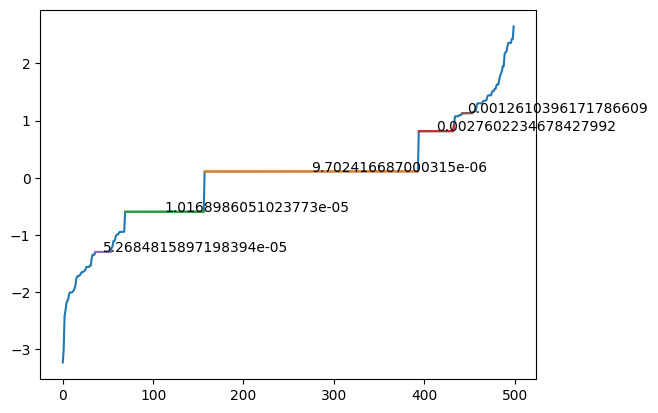

In [249]:
clusters = [to_cluster_barg(arg_psize[i],peaks_new) for i in range(len(arg_psize))]
print(*list(map(len,clusters)))
print(*list(map(to_cstability,clusters)))
print(*list(map(to_mean_avg_d_o,clusters)))

plt.plot(avg_dtheta[-1][arg])
for i in range(5):
    # i = 0
    x = to_cluster_bargx(arg_psize[i])[:]
    y = avg_dtheta[-1][arg][x]
    plt.plot(x,y)
    plt.text(np.mean(x),np.mean(y),f'{np.mean(diff_dtheta[x[1:]])}')

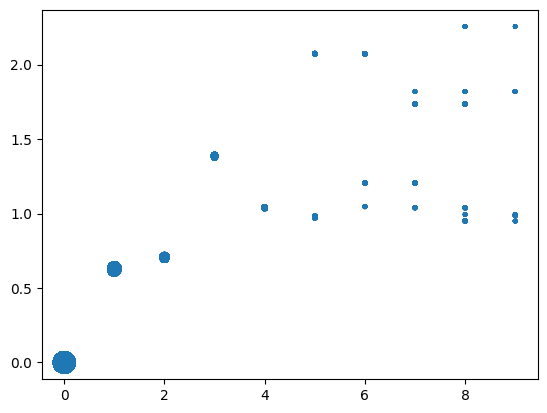

In [250]:
plt.scatter(np.array([np.arange(10) for i in range(1000)]),abs(mean_omega_array-mean_omega_array[0]).T,s=psize_array.T);

In [42]:
mean_omega

array([ 0.03495559, -1.49706609,  2.2668969 ,  1.37804924, -1.88075726,
       -1.03196914, -1.77905668, -1.27398378,  1.65887824, -2.03190253])

In [252]:

print(Is_group)
L_cluster = {}
R_cluster = {}
M_cluster = []

num = 0
L_cluster_sort = {}
R_cluster_sort = {}
M_cluster_sort = []
if len(Is_group[0]) !=0:
    for index in range(-iter_time,0):
        arg = np.argsort(avg_dtheta[index])
        SD = avg_dtheta[index][arg]
        diff_dtheta = np.diff([SD[0],*SD])
        peaks, P  = find_peaks(diff_dtheta, height=0.01)
        peaks = peaks[np.where((peaks<N)&(peaks>1))]

        try:
            peaks_new = np.array([peaks[0],*peaks])
        except IndexError:
            peaks_new = np.array([0,N])
        psize = np.diff(peaks_new)
        arg_psize = np.argsort(psize)[::-1]

        if -iter_time == index:
            sort_psize = np.sort(psize)[::-1]
            
            IS_main = []
            for i in range(10):
                C = arg_psize[i],arg_psize[i]+1
                arg_C = peaks_new[C[0]],peaks_new[C[1]]
                cluster = arg[arg_C[0]:arg_C[1]]
                if (N//2 in cluster)&(num==0):
                    main_i = i
                    num+=1
                IS_main.append(np.mean(abs(cluster -N//2)))
            main_i = np.argmin(IS_main)
            main_10 = arg_psize[:10][Is_group]
            
            M_cluster_idx = main_10[main_i]
            L_cluster_idx = main_10[main_10<main_10[main_i]]
            L_cluster_g = Is_group[0][main_10<main_10[main_i]]
            R_cluster_idx = main_10[main_10>main_10[main_i]]
            R_cluster_g = Is_group[0][main_10>main_10[main_i]]
            for i,idx in enumerate(L_cluster_idx):
                L_c = to_cluster(idx,peaks_new=peaks_new,arg=arg)
                L_cluster[i] = L_c
                print('L',i,idx,len(L_c),psize[idx])
            for i,idx in enumerate(R_cluster_idx):
                R_c = to_cluster(idx,peaks_new=peaks_new,arg=arg)
                R_cluster[i] = R_c
                print('R',i,idx,len(R_c),psize[idx])
            M_cluster = to_cluster(M_cluster_idx,peaks_new=peaks_new,arg=arg)
            print("M",len(M_cluster))
            # break
        else:
            main_10 = arg_psize[:10][Is_group]
            M_cluster_idx = main_10[main_i]
            L_cluster_idx = arg_psize[:10][L_cluster_g]
            R_cluster_idx = arg_psize[:10][R_cluster_g]
            M_cluster = np.c_[M_cluster,to_cluster(M_cluster_idx,peaks_new=peaks_new,arg=arg)]

            for i,Lidx in enumerate(L_cluster_idx):
                try:
                    L_cluster[i] = np.c_[L_cluster[i],to_cluster(Lidx,peaks_new=peaks_new,arg=arg)]
                except ValueError:
                    print(L_cluster[i].shape,len(to_cluster(Lidx,peaks_new=peaks_new,arg=arg)))

            for i,Ridx in enumerate(R_cluster_idx):
                try:
                    R_cluster[i] = np.c_[R_cluster[i],to_cluster(Ridx,peaks_new=peaks_new,arg=arg)]
                except ValueError:
                    print(R_cluster[i].shape,len(to_cluster(Ridx,peaks_new=peaks_new,arg=arg)))
                    # break

(array([0, 1, 2, 3, 4], dtype=int64),)
L 0 16 88 88
L 1 10 18 18
R 0 18 39 39
R 1 20 13 13
M 237
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 579) 40
(39, 5

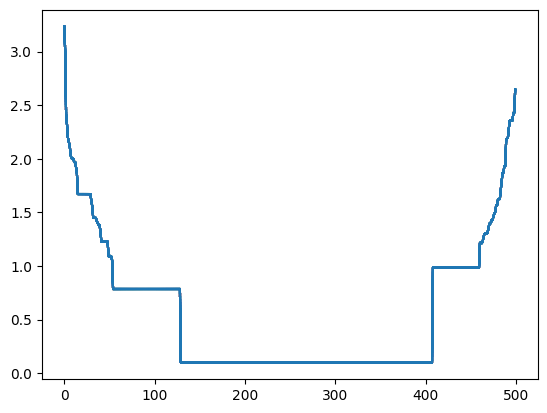

In [143]:
plt.plot(abs(avg_dtheta[-100:].T),alpha=0.1,zorder=0,color ='tab:blue');


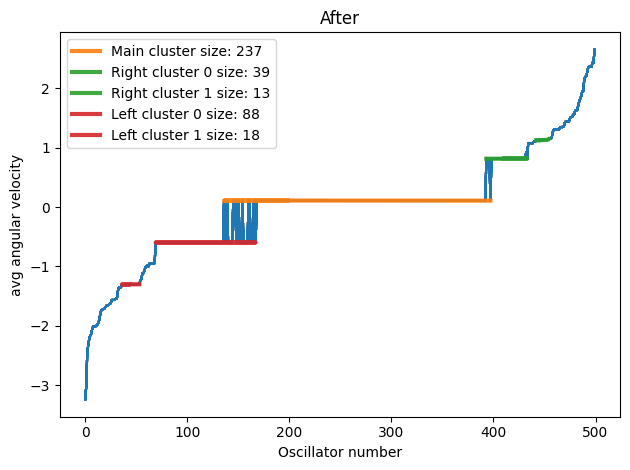

In [253]:
main_10 = arg_psize[:10]
plt.plot(avg_dtheta[-100:].T,alpha=0.1,zorder=0,color ='tab:blue')
cluster = M_cluster[:,-1]
plt.plot(cluster,avg_dtheta[-1][cluster],color = 'tab:orange',lw=3,alpha=0.9,label = f'Main cluster size: {len(cluster)}',zorder=1)
for i,idx in enumerate(R_cluster.keys()):
    cluster = R_cluster[i][:,-1]
    plt.plot(cluster,avg_dtheta[-1][cluster],color = 'tab:green',lw=3,alpha=0.9,label = f'Right cluster {i} size: {len(cluster)}',zorder=1)
for i,idx in enumerate(L_cluster.keys()):
    cluster = L_cluster[i][:,-1]
    plt.plot(cluster,avg_dtheta[-1][cluster],color = 'tab:red',lw=3,alpha=0.9,label = f'Left cluster {i} size: {len(cluster)}',zorder=1)




plt.title('After')
plt.xlabel('Oscillator number')
plt.ylabel('avg angular velocity')
plt.legend()
plt.tight_layout()